# Stackoverflow Survey results, 2017 analysis
In this project I will analyze the Stackoverflow survey results of 2017 in order to glean the information that how can people in developer roles be more successful.
I will answer three questions, namely:

What is the demographic of the people surveyed?

What factors lead to job satisfaction?

What factors lead to higher salary and does job satisfaction translate to more money and vice-versa?

In [637]:
# Import libraries
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
#import AllTogether as t
import seaborn as sns
%matplotlib inline

# Getting to know the survey data

In [669]:
#Read the survey file
df = pd.read_csv('./survey_results_public.csv')

In [640]:
df.describe()

,Respondent,CareerSatisfaction,JobSatisfaction,HoursPerWeek,StackOverflowSatisfaction,Salary,ExpectedSalary
count,19102.000000,16102.000000,15253.000000,7721.000000,13452.000000,5009.000000,818.000000
mean,9551.500000,7.343932,7.000721,3.685922,8.357865,58341.398571,32231.521687
std,5514.416757,1.919330,2.128648,7.330691,1.405546,40753.384986,28543.877274
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4776.250000,6.000000,6.000000,0.000000,8.000000,27956.989247,4716.459735
50%,9551.500000,8.000000,7.000000,1.000000,8.000000,51612.903226,29784.946237
75%,14326.750000,9.000000,8.000000,3.000000,9.000000,83333.333333,50000.000000
max,19102.000000,10.000000,10.000000,40.000000,10.000000,195000.000000,120000.000000


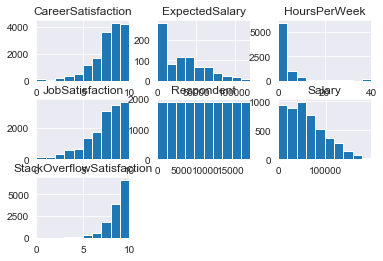

In [641]:
df.hist();

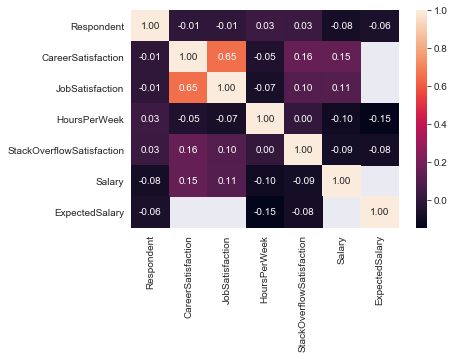

In [642]:
# Correlation map
sns.heatmap(df.corr(), annot=True, fmt=".2f");

# Getting to know the attributes in the survey file using schema file

In [643]:
#Read the schema file containing the attribute descriptions
schema = pd.read_csv('./survey_results_schema.csv')

In [647]:
#get_description function picked up from udacity code
def get_description(column_name, schema=schema):
    '''
    INPUT - schema - pandas dataframe with the schema of the developers survey
            column_name - string - the name of the column you would like to know about
    OUTPUT - 
            desc - string - the description of the column
    '''
    desc = list(schema[schema['Column']==column_name]['Question'])[0]
    return desc

In [645]:
#Data types in the survey results dataframe
df.dtypes.value_counts()

object     147
float64      6
int64        1
dtype: int64

In [648]:
#Column descriptions for quick review
columns_type_object=[]
for index, value in df.dtypes.iteritems():
    if value == object:
        columns_type_object.append(index)
print(columns_type_object)
df_object=pd.DataFrame({'Attribute':columns_type_object, 'Description':columns_type_object})
df_object['Description'].apply(lambda x: get_description(x))

['Professional', 'ProgramHobby', 'Country', 'University', 'EmploymentStatus', 'FormalEducation', 'MajorUndergrad', 'HomeRemote', 'CompanySize', 'CompanyType', 'YearsProgram', 'YearsCodedJob', 'YearsCodedJobPast', 'DeveloperType', 'WebDeveloperType', 'MobileDeveloperType', 'NonDeveloperType', 'ExCoderReturn', 'ExCoderNotForMe', 'ExCoderBalance', 'ExCoder10Years', 'ExCoderBelonged', 'ExCoderSkills', 'ExCoderWillNotCode', 'ExCoderActive', 'PronounceGIF', 'ProblemSolving', 'BuildingThings', 'LearningNewTech', 'BoringDetails', 'JobSecurity', 'DiversityImportant', 'AnnoyingUI', 'FriendsDevelopers', 'RightWrongWay', 'UnderstandComputers', 'SeriousWork', 'InvestTimeTools', 'WorkPayCare', 'KinshipDevelopers', 'ChallengeMyself', 'CompetePeers', 'ChangeWorld', 'JobSeekingStatus', 'LastNewJob', 'AssessJobIndustry', 'AssessJobRole', 'AssessJobExp', 'AssessJobDept', 'AssessJobTech', 'AssessJobProjects', 'AssessJobCompensation', 'AssessJobOffice', 'AssessJobCommute', 'AssessJobRemote', 'AssessJobLead

0             Which of the following best describes you?
1      Do you program as a hobby or contribute to ope...
2                In which country do you currently live?
3      Are you currently enrolled in a formal, degree...
4      Which of the following best describes your cur...
5      Which of the following best describes the high...
6      Which of the following best describes your mai...
7           How often do you work from home or remotely?
8      In terms of the number of employees, how large...
9      Which of the following best describes the type...
10     How long has it been since you first learned h...
11     For how many years have you coded as part of y...
12     For how many years did you code as part of you...
13             Which of the following best describe you?
14     Which of the following best describes you as a...
15     For which of the following platforms do you de...
16                  Which of the following describe you?
17     You said before that you

# Data preparation

In [657]:
# Udacity code
gender_vals = df.Gender.value_counts()#Provide a pandas series of the counts for each Gender

gender_vals # assure this looks right

Male                                                       11664
Female                                                       970
Other                                                         73
Gender non-conforming                                         54
Male; Other                                                   42
Female; Transgender                                           28
Transgender                                                   20
Male; Gender non-conforming                                   19
Female; Gender non-conforming                                 11
Transgender; Gender non-conforming                             5
Male; Female                                                   5
Male; Transgender                                              4
Male; Female; Transgender; Gender non-conforming; Other        4
Female; Transgender; Gender non-conforming                     3
Male; Female; Transgender; Gender non-conforming               2
Male; Female; Transgender

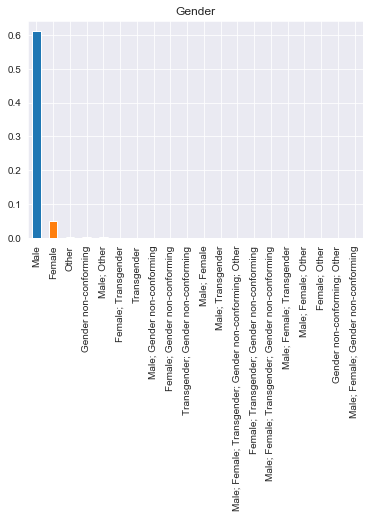

In [658]:
#Gender plot, the plot below is not clean
(gender_vals/df.shape[0]).plot(kind="bar");
plt.title("Gender");

#### We can see from the plot above that the data is not clean

In [659]:
# Udacity code
# This function will allow us to do a lookup operation and count the total no of occurences
def total_count(df, col1, col2, look_for):
    '''
    INPUT:
    df - the pandas dataframe you want to search
    col1 - the column name you want to look through
    col2 - the column you want to count values from
    look_for - a list of strings you want to search for in each row of df[col]

    OUTPUT:
    new_df - a dataframe of each look_for with the count of how often it shows up
    '''
    new_df = defaultdict(int)
    #loop through list of ed types
    for val in look_for:
        #loop through rows
        for idx in range(df.shape[0]):
            #if the ed type is in the row add 1
            if val in df[col1][idx]:
                new_df[val] += int(df[col2][idx])
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values('count', ascending=False, inplace=True)
    return new_df

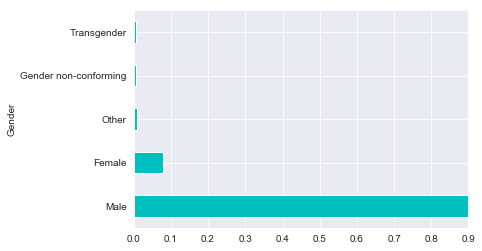

<Figure size 432x288 with 0 Axes>

In [660]:
possible_vals = ["Male", "Female", "Transgender", "Gender non-conforming", "Other"]

# This function will clean and plot the data
# Udacity code
def clean_and_plot(df, title, plot=True):
    '''
    INPUT 
        df - a dataframe holding the CousinEducation column
        title - string the title of your plot
        axis - axis object
        plot - bool providing whether or not you want a plot back
        
    OUTPUT
        study_df - a dataframe with the count of how many individuals
        Displays a plot of pretty things related to the CousinEducation column.
    '''
    study = df[title].value_counts().reset_index()
    study.rename(columns={'index': title, title: 'count'}, inplace=True)
    study_df = total_count(study, title, 'count', possible_vals)

    study_df.set_index(title, inplace=True)
    if plot:
        (study_df/study_df.sum()).plot(kind='barh',color='c', legend=None);
        #plt.title(title);
        plt.show()
        plt.savefig(title, bbox_inches='tight', pad_inches=0.5);
    props_study_df = study_df/study_df.sum()
    return props_study_df
    
props_df = clean_and_plot(df, 'Gender')

#### Cleaned data for Gender attribute

In [662]:
df['JobSatisfaction'].isnull().mean() # missing values

0.20149722542142184

In [663]:
#Gender based job satisfaction
df.groupby(['Gender']).mean()['JobSatisfaction'].sort_values(ascending= False)

Gender
Male; Transgender                                          8.666667
Gender non-conforming; Other                               8.000000
Male; Female; Transgender; Gender non-conforming           8.000000
Male; Other                                                7.566667
Female; Gender non-conforming                              7.500000
Male                                                       7.063321
Female                                                     7.049057
Female; Transgender; Gender non-conforming                 7.000000
Transgender; Gender non-conforming                         7.000000
Female; Transgender                                        6.600000
Other                                                      6.465116
Transgender                                                6.437500
Male; Gender non-conforming                                6.428571
Gender non-conforming                                      6.222222
Male; Female; Transgender                

In [668]:
df.Race.unique() # Number of unique races in the dataset, we can observe that the data is quite messy

array(['White or of European descent', nan, 'Hispanic or Latino/Latina',
       'Native American, Pacific Islander, or Indigenous Australian; White or of European descent',
       'I prefer not to say', 'South Asian', 'Middle Eastern',
       'Hispanic or Latino/Latina; White or of European descent',
       'I don’t know',
       'Hispanic or Latino/Latina; Native American, Pacific Islander, or Indigenous Australian',
       'Middle Eastern; White or of European descent', 'East Asian',
       'Black or of African descent; White or of European descent',
       'Black or of African descent; East Asian; White or of European descent',
       'Middle Eastern; I don’t know',
       'East Asian; White or of European descent',
       'East Asian; South Asian; I don’t know', 'East Asian; South Asian',
       'Black or of African descent',
       'Native American, Pacific Islander, or Indigenous Australian',
       'Black or of African descent; Middle Eastern',
       'Black or of African descen

In [665]:
possible_vals = ['White or of European descent', 'Native American', 'Hispanic or Latino/Latina', 'Middle Eastern', 
'Black or of African descent', 'East Asian', 'South Asian', 'Pacific Islander', 'South Asian', 'Indigenous Australian'
]

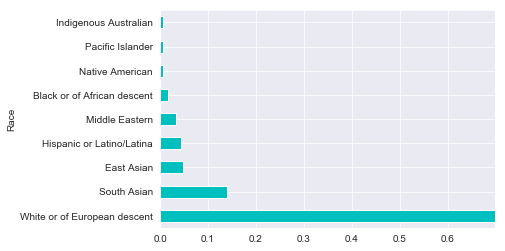

<Figure size 432x288 with 0 Axes>

In [666]:
props_df = clean_and_plot(df, 'Race')

##### Cleaned data for Race

In [667]:
#Gender based salaries
#Nan values dropped to provide only relevant data, otherwise the graph will be cluttered.
df.groupby(['Gender']).mean()['Salary'].sort_values(ascending= False).dropna()

Gender
Transgender                                                93125.000000
Female; Transgender                                        93075.725027
Male; Transgender                                          90827.272727
Female; Transgender; Gender non-conforming                 90750.000000
Male; Female; Transgender; Gender non-conforming; Other    77675.554968
Male; Gender non-conforming                                74421.786994
Gender non-conforming                                      67399.987781
Female; Gender non-conforming                              65103.787879
Male; Other                                                63491.419071
Transgender; Gender non-conforming                         59086.021505
Male                                                       59080.990450
Female                                                     57000.666971
Male; Female                                               55385.300974
Other                                                    

# Graphical analysis of the data

In [649]:
def plots_series(df, title, yaxis, kind, rot, size_xlabel): 
    '''
    Input: Pandas series
    df-Pandas series, 
    title- title of the figure
    yaxis- y axis label
    kind- type of plot bar, line, barh, etc
    rot- rotation of labels on x axis
    size_xlabel- label size of x axis
    
    Output: Plot
    '''
    fig, ax = plt.subplots(figsize=(25,10))
    df.plot(kind=kind, rot= rot, use_index= True, grid = True, legend=None, 
            color='c', subplots= True);
    if title!=None:
        plt.title(title);
    ax.tick_params(rotation = (rot), labelsize = size_xlabel, axis='x')

    if yaxis!=None:
        ax.set_ylabel(yaxis)
    plt.savefig(title, bbox_inches='tight', pad_inches=0.5);

In [656]:
#Nans not removed
df.groupby(['Gender']).mean()['Salary'].sort_values()

Gender
Male; Female; Transgender                                  12000.000000
Male; Female; Other                                        15000.000000
Other                                                      49456.283362
Male; Female                                               55385.300974
Female                                                     57000.666971
Male                                                       59080.990450
Transgender; Gender non-conforming                         59086.021505
Male; Other                                                63491.419071
Female; Gender non-conforming                              65103.787879
Gender non-conforming                                      67399.987781
Male; Gender non-conforming                                74421.786994
Male; Female; Transgender; Gender non-conforming; Other    77675.554968
Female; Transgender; Gender non-conforming                 90750.000000
Male; Transgender                                        

In [652]:
# Gender vs Salary
#Nan values dropped to provide only relevant data, otherwise the graph will be cluttered.
Gender_S=df.groupby(['Gender']).mean()['Salary'].sort_values().dropna()

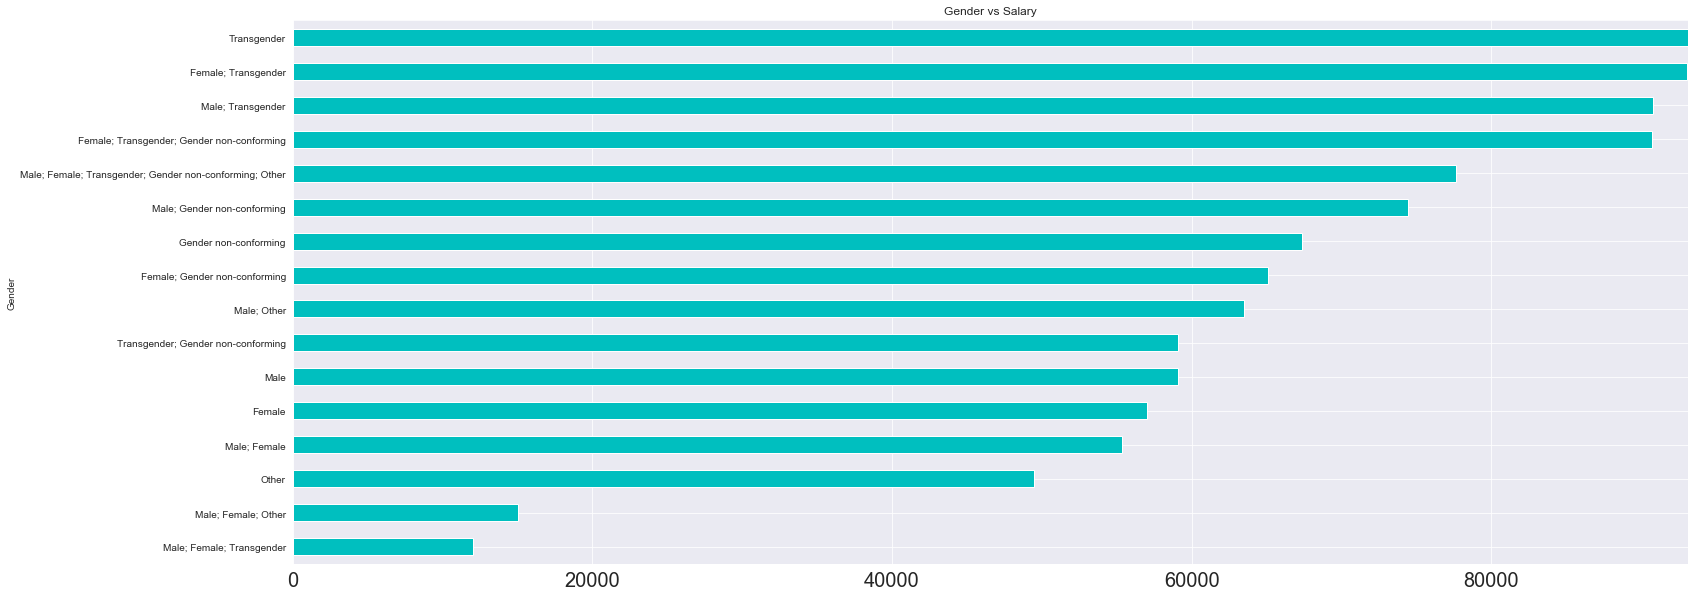

In [653]:
# Gender vs Salary plot
plots_series(Gender_S, 'Gender vs Salary', None, 'barh', 0, 20)

In [597]:
# Gender vs Job Satisfaction
#Nan values dropped to provide only relevant data, otherwise the graph will be cluttered.
Gender=df.groupby(['Gender']).mean()['JobSatisfaction'].sort_values().dropna()

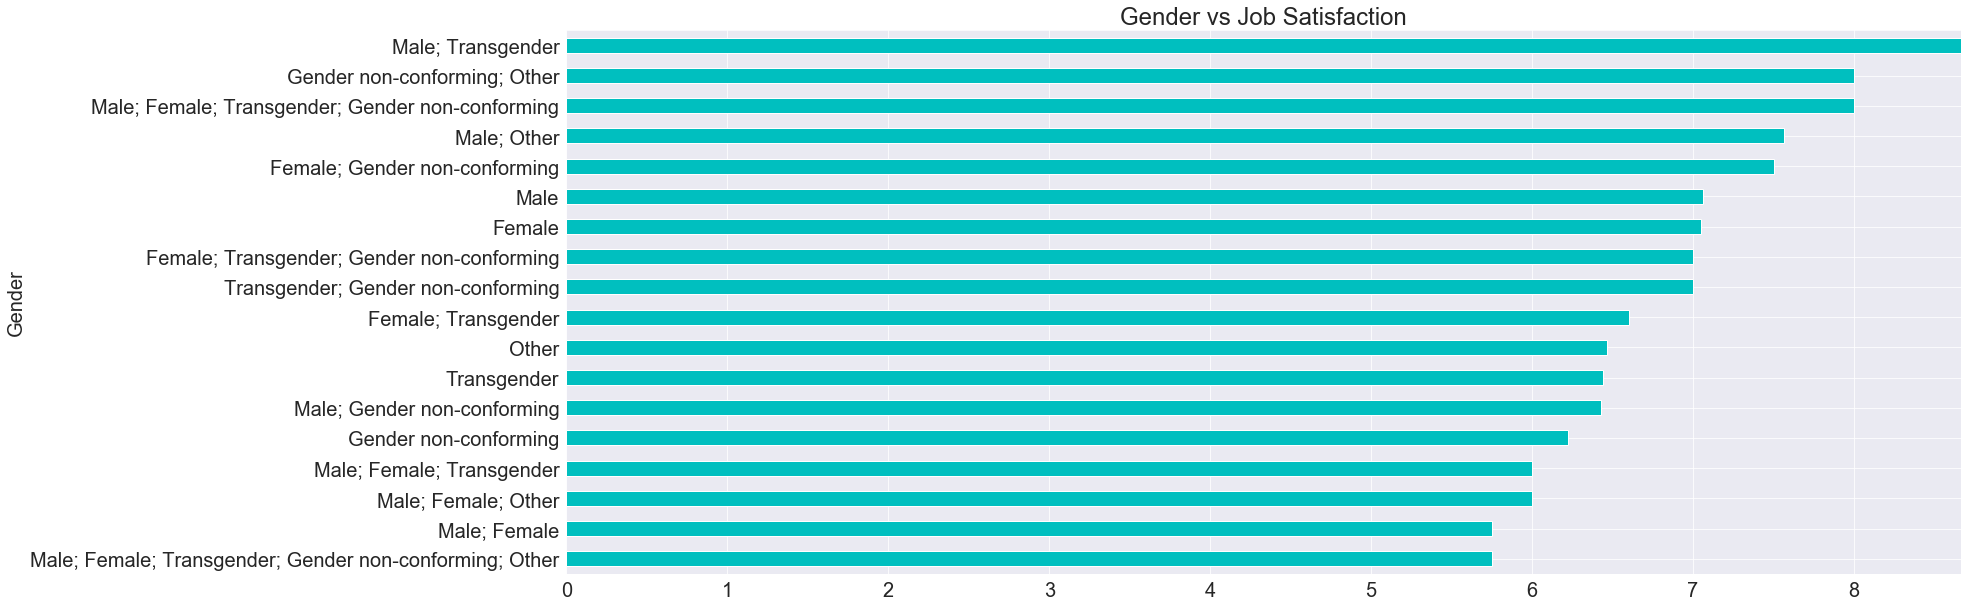

In [598]:
plots_series(Gender, 'Gender vs Job Satisfaction', None, 'barh', 0, 20)

In [573]:
# calculation of percentage of respondents for each country
dff = pd.DataFrame(df['Country'].value_counts())
dff['count'] = dff['Country']
dff['Country'] = dff['Country'].apply(lambda x: x/dff['Country'].mean())
dff.rename(columns={'Country': 'Percentage of Respondents'}, inplace=True)

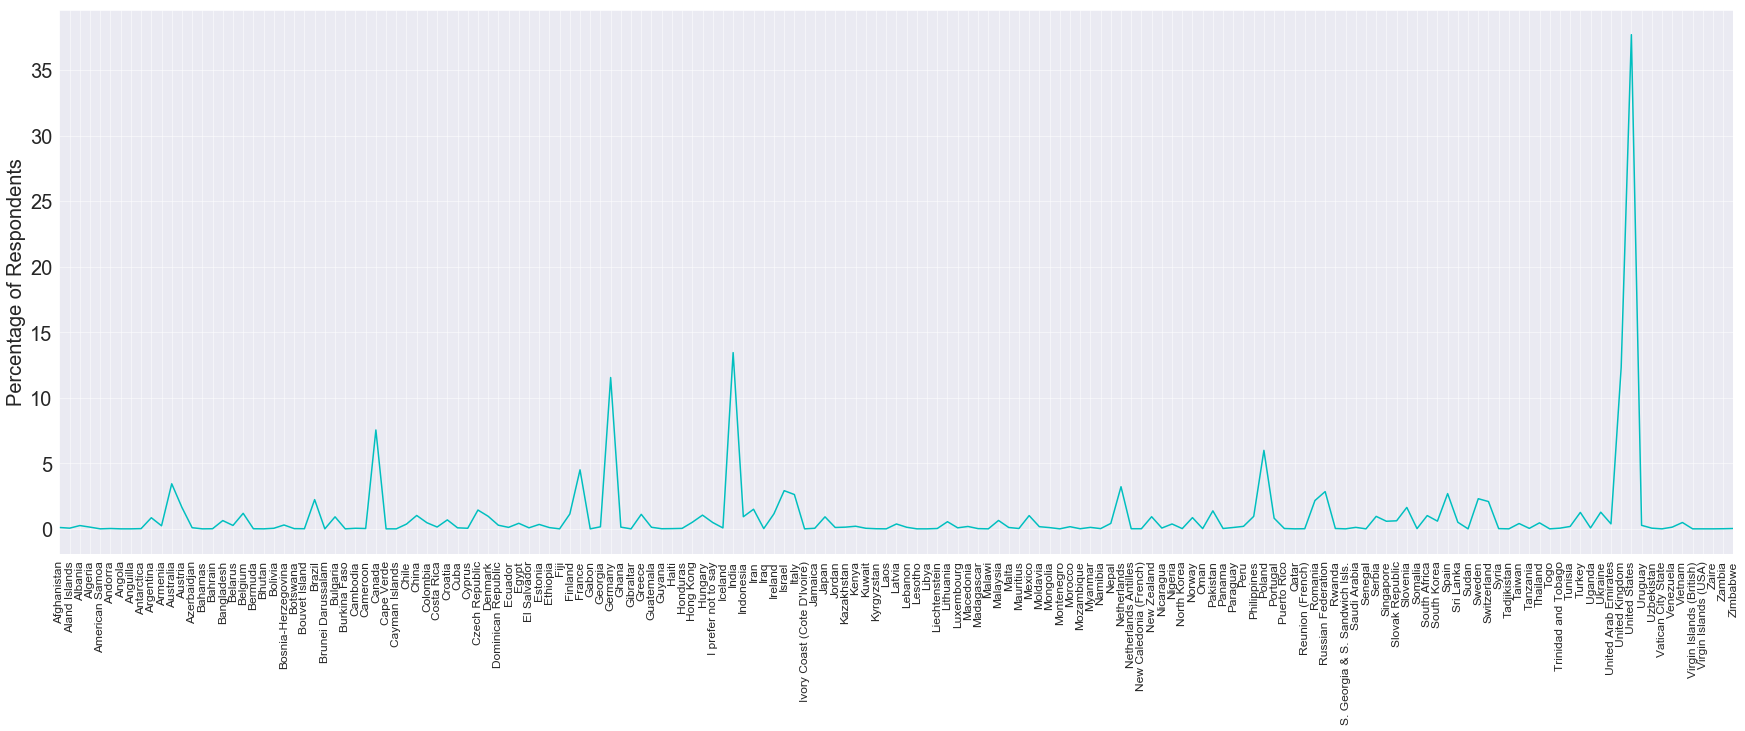

In [542]:
#Plot of respondents vs Country
fig, ax = plt.subplots(figsize=(30,10))
sns.lineplot(x=dff.index, y= dff['Percentage of Respondents'], color='c')

ax.tick_params(rotation = (90), labelsize = 12, axis='x')
ax.tick_params(labelsize = 20, axis='y')

plt.rcParams['axes.xmargin'] = 0;
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='major', color='w', linewidth=0.5)
sns.set_style('darkgrid')
plt.savefig('Country', bbox_inches='tight', pad_inches=0.5);

In [654]:
# company type vs salary
#Nan values dropped to provide only relevant data, otherwise the graph will be cluttered.
CompanyType_S=df.groupby(['CompanyType']).mean()['Salary'].sort_values().dropna()

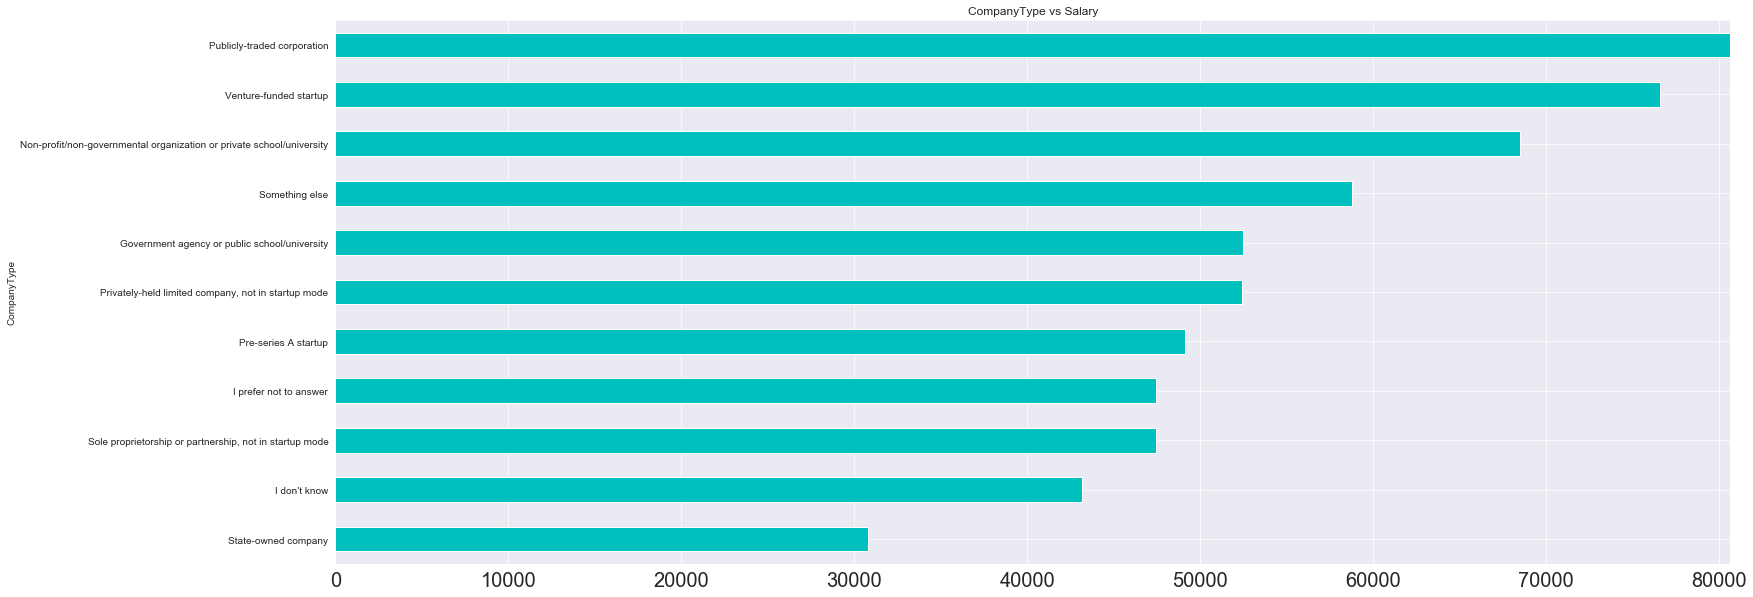

In [655]:
plots_series(CompanyType_S, 'CompanyType vs Salary', None, 'barh', 0, 20)

In [501]:
#CompanyType vs Satisfaction
#Nan values dropped to provide only relevant data, otherwise the graph will be cluttered.
CompanyType=df.groupby(['CompanyType']).mean()['JobSatisfaction'].sort_values().dropna()

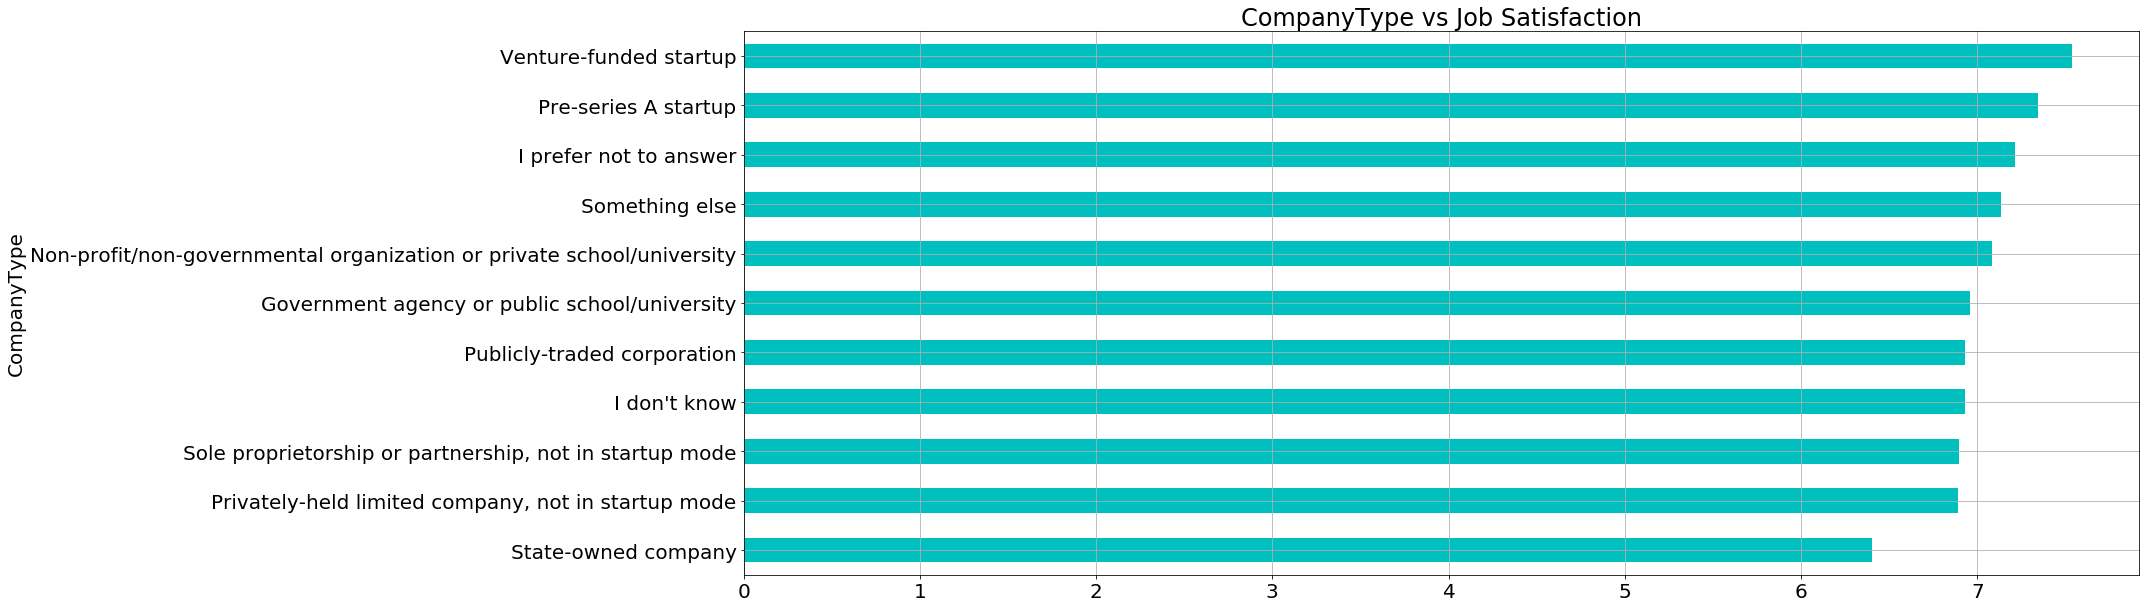

In [507]:
plots_series(CompanyType, 'CompanyType vs Job Satisfaction', None, 'barh', 0, 20)

In [610]:
#Value counts to check how many samples for 18 hours
df['HoursPerWeek'].value_counts()

1.0     2231
0.0     2062
2.0     1111
3.0      454
4.0      403
5.0      328
10.0     169
40.0     169
6.0      157
8.0      116
20.0      86
7.0       86
15.0      47
12.0      38
9.0       26
14.0      24
30.0      22
11.0      21
35.0      19
16.0      18
21.0      17
13.0      16
22.0      11
25.0      10
19.0       9
24.0       9
17.0       8
18.0       8
27.0       6
39.0       6
32.0       5
28.0       5
38.0       5
23.0       5
26.0       4
37.0       4
34.0       2
29.0       2
36.0       2
Name: HoursPerWeek, dtype: int64

In [606]:
# HoursPerWeek vs salary
#Nan values dropped to provide only relevant data, otherwise the graph will be cluttered.
HoursPerWeek_S=df.groupby(['HoursPerWeek']).mean()['Salary'].dropna()

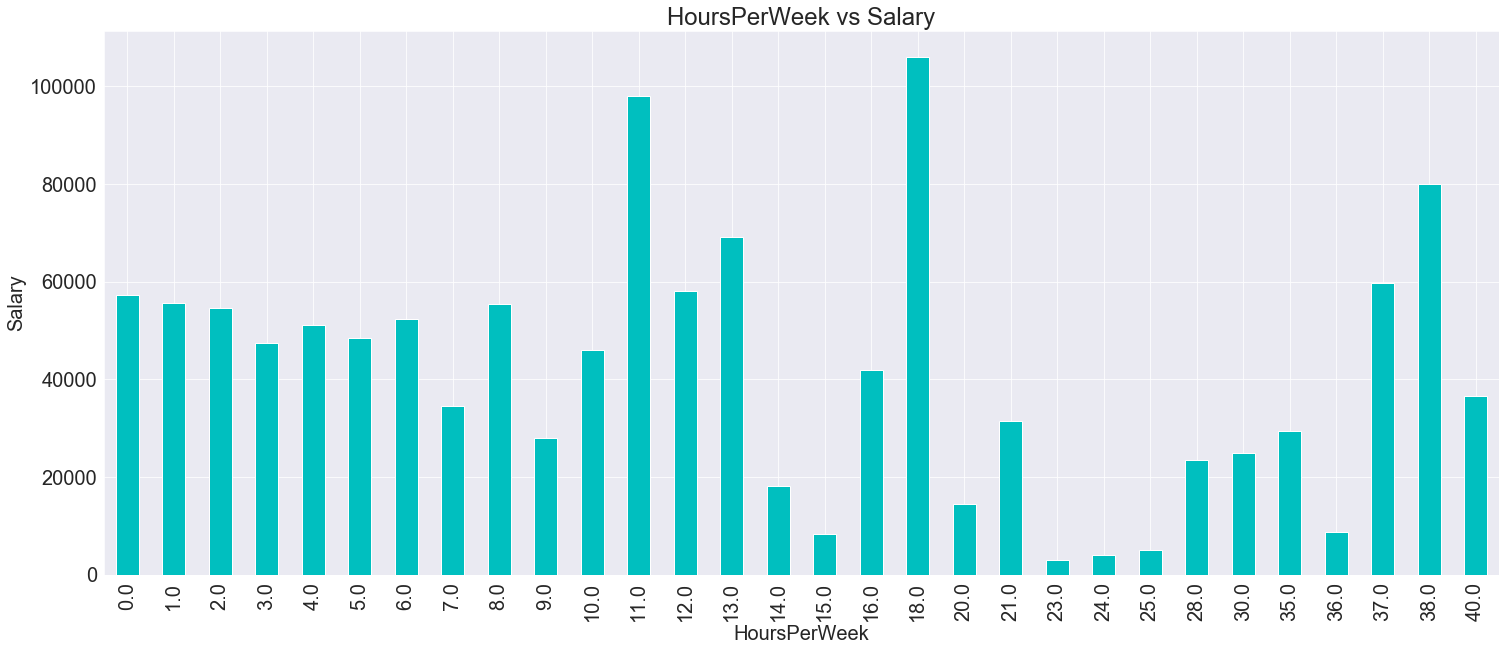

In [611]:
plots_series(HoursPerWeek_S, 'HoursPerWeek vs Salary', 'Salary', 'bar', 90, 20)

In [492]:
#HoursPerWeek vs Satisfaction
#Nan values dropped to provide only relevant data, otherwise the graph will be cluttered.
HoursPerWeek=df.groupby(['HoursPerWeek']).mean()['JobSatisfaction'].dropna()

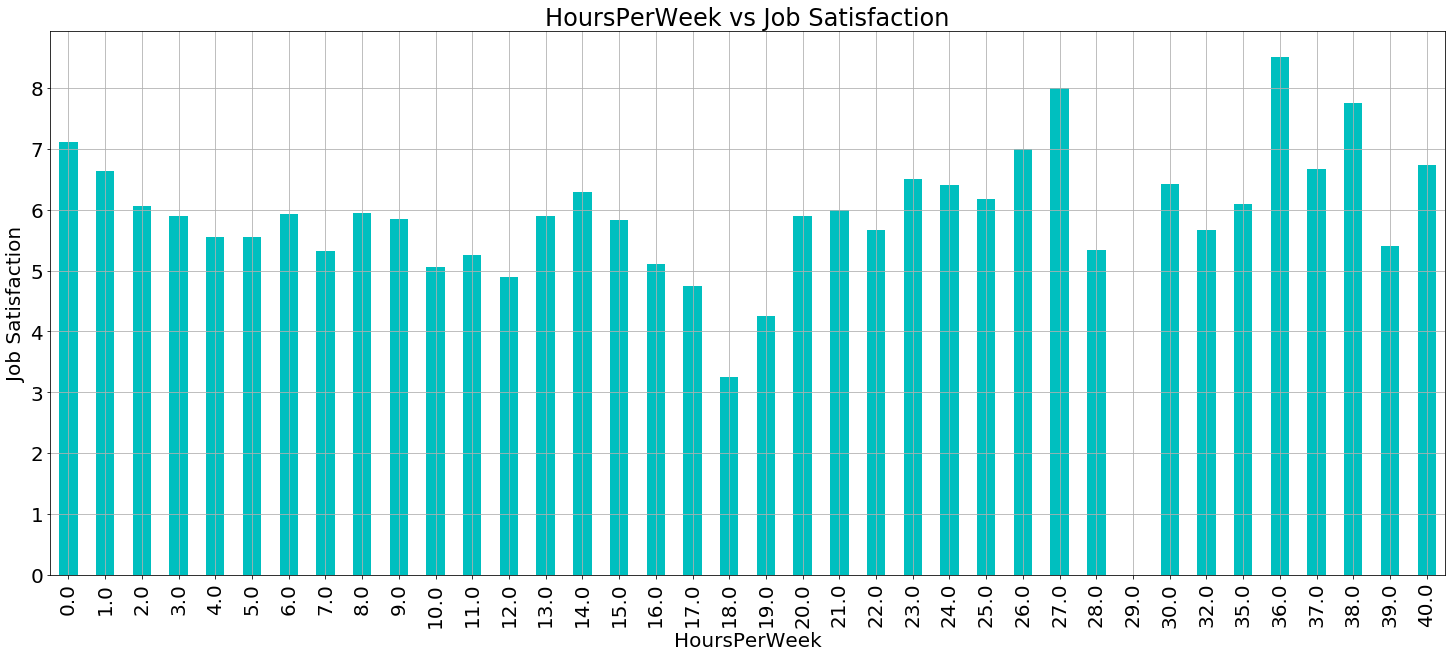

In [500]:
plots_series(HoursPerWeek, 'HoursPerWeek vs Job Satisfaction', 'Job Satisfaction', 'bar', 90, 20)

In [614]:
#What does workpaycare imply
get_description('WorkPayCare')

"I don't really care what I work on, so long as I'm paid well"

In [612]:
#WorkPayCare vs Salary
#Nan values dropped to provide only relevant data, otherwise the graph will be cluttered.
WorkPayCare_S=df.groupby(['WorkPayCare']).mean()['Salary'].sort_values(ascending = False).dropna()

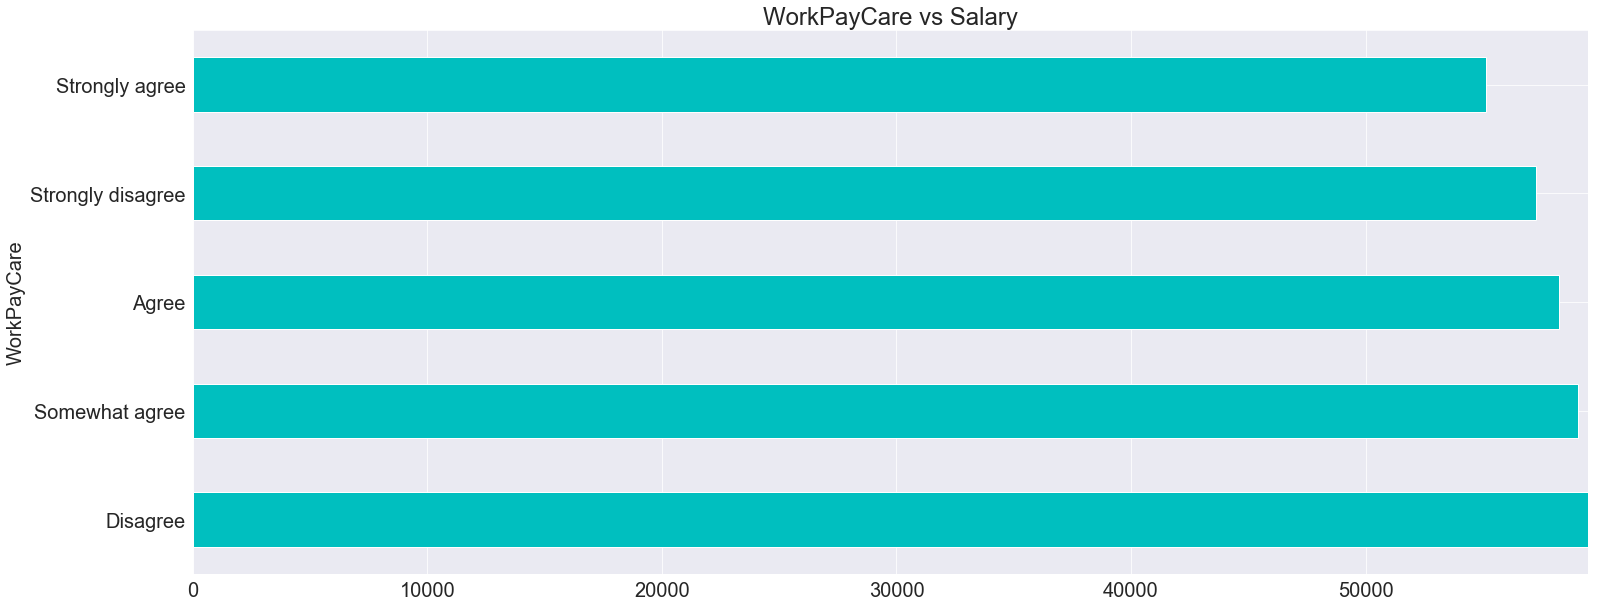

In [633]:
plots_series(WorkPayCare_S, 'WorkPayCare vs Salary', 'WorkPayCare', 'barh', 0, 20)

In [469]:
#WorkPayCare vs Satisfaction
#Nan values dropped to provide only relevant data, otherwise the graph will be cluttered.
WorkPayCare=df.groupby(['WorkPayCare']).mean()['JobSatisfaction'].sort_values(ascending = False).dropna()

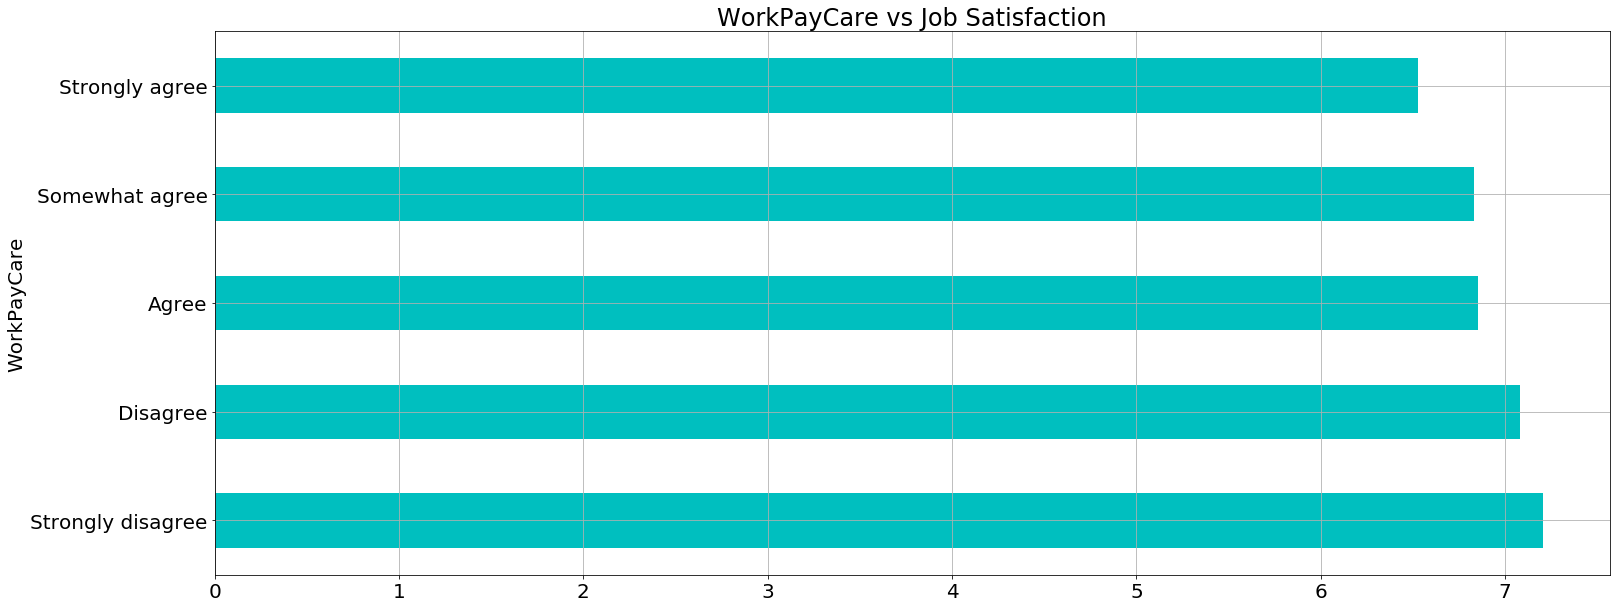

In [515]:
plots_series(WorkPayCare, 'WorkPayCare vs Job Satisfaction', 'WorkPayCare', 'barh', 0, 20)

In [616]:
# Remote work vs Salary
#Nan values dropped to provide only relevant data, otherwise the graph will be cluttered.
HomeRemote_S=df.groupby(['HomeRemote']).mean()['Salary'].sort_values(ascending = False).dropna()

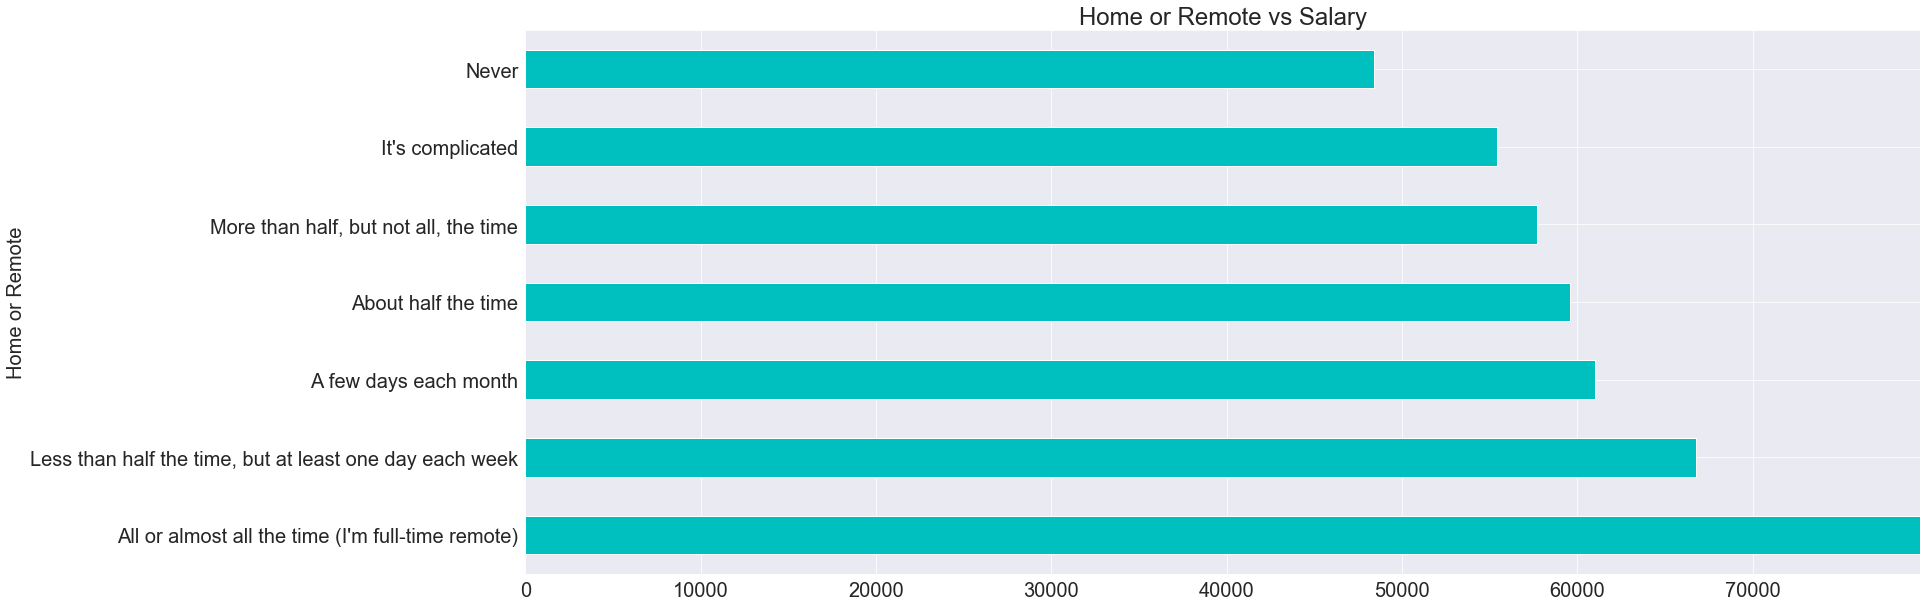

In [617]:
plots_series(HomeRemote_S, 'Home or Remote vs Salary', 'Home or Remote', 'barh', 0, 20)

In [465]:
# Remote work vs Satisfaction
#Nan values dropped to provide only relevant data, otherwise the graph will be cluttered.
HomeRemote=df.groupby(['HomeRemote']).mean()['JobSatisfaction'].sort_values(ascending = False).dropna()

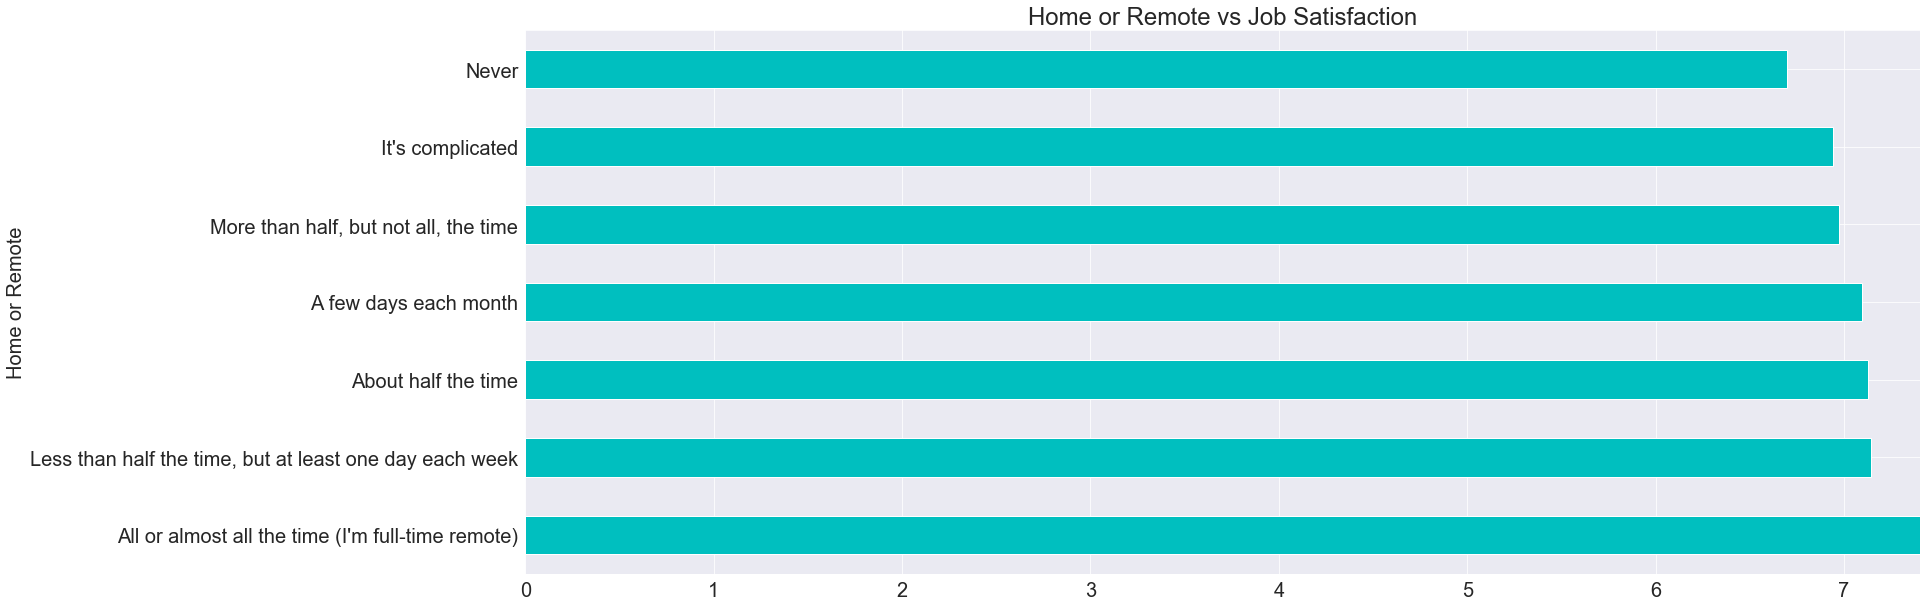

In [599]:
plots_series(HomeRemote, 'Home or Remote vs Job Satisfaction', 'Home or Remote', 'barh', 0, 20)

In [618]:
#Major in Undergrad vs Salary
#Nan values dropped to provide only relevant data, otherwise the graph will be cluttered.
MajorUndergrad_S=df.groupby(['MajorUndergrad']).mean()['Salary'].sort_values(ascending = False).dropna()

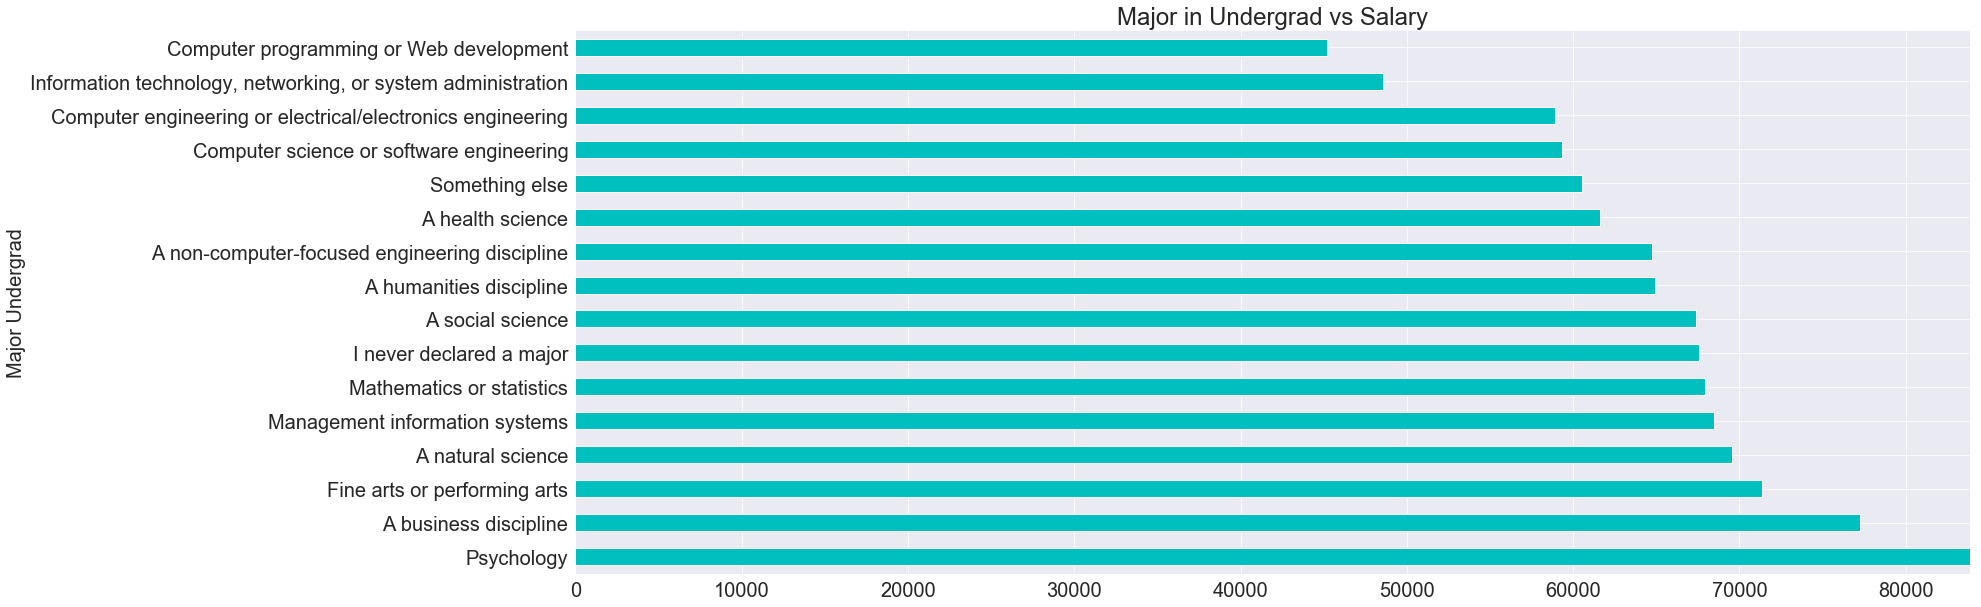

In [620]:
plots_series(MajorUndergrad_S, 'Major in Undergrad vs Salary', 'Major Undergrad', 'barh', 0, 20)

In [462]:
#Major in Undergrad vs Satisfaction
#Nan values dropped to provide only relevant data, otherwise the graph will be cluttered.
MajorUndergrad=df.groupby(['MajorUndergrad']).mean()['JobSatisfaction'].sort_values(ascending = False).dropna()

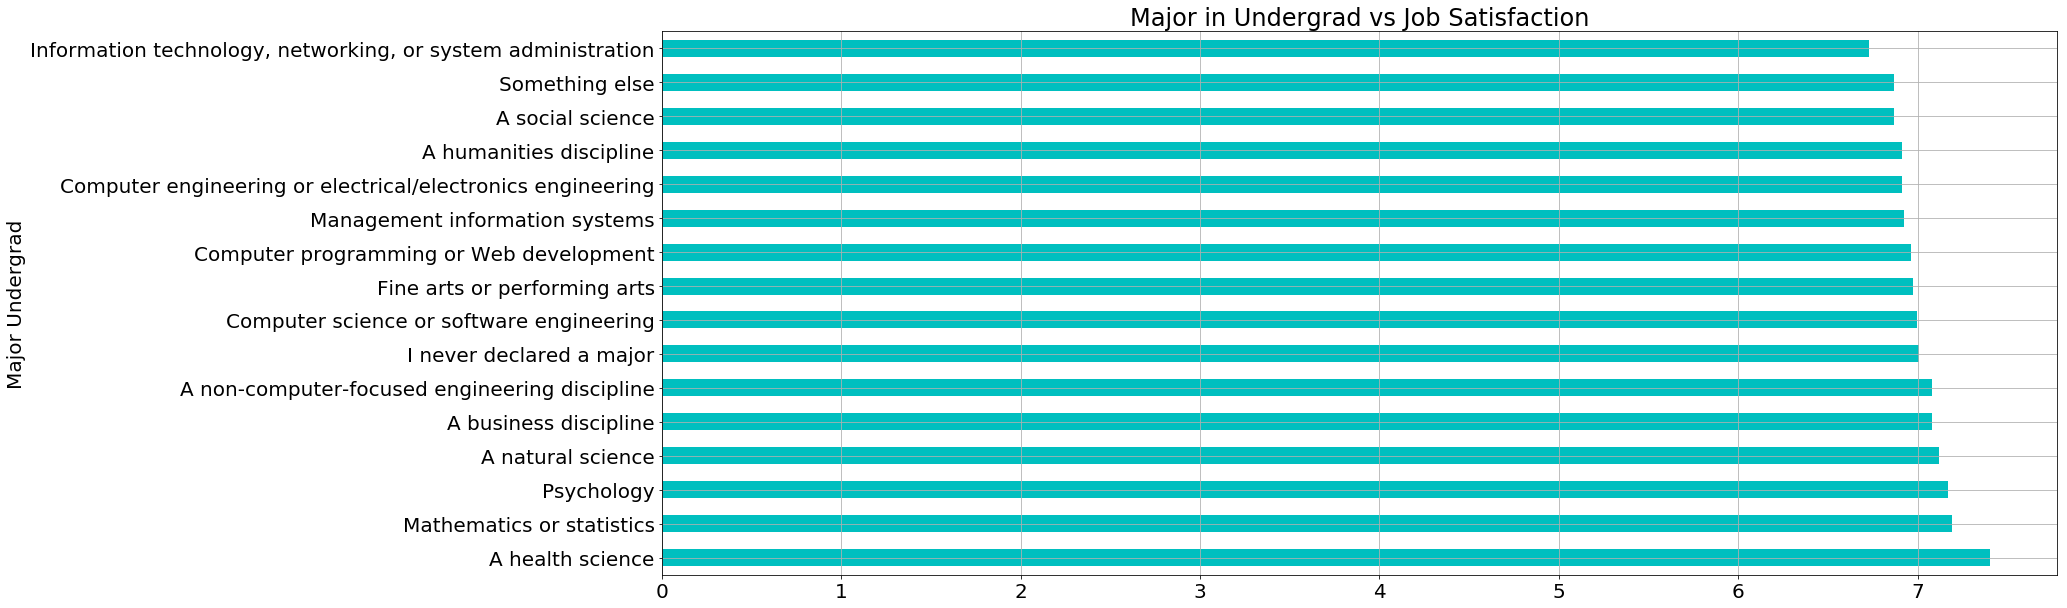

In [510]:
plots_series(MajorUndergrad, 'Major in Undergrad vs Job Satisfaction', 'Major Undergrad', 'barh', 0, 20)

In [636]:
#Primary/elementary school sample quick check
df[df.FormalEducation=='Primary/elementary school']

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
15,16,Professional developer,"Yes, I program as a hobby",United States,"Yes, part-time","Independent contractor, freelancer, or self-em...",Primary/elementary school,NaN,All or almost all the time (I'm full-time remote),NaN,...,Disagree,Male,A doctoral degree,White or of European descent,Disagree,Somewhat agree,Strongly disagree,Agree,NaN,NaN
109,110,Professional developer,"Yes, I program as a hobby",United States,No,Employed full-time,Primary/elementary school,NaN,Never,Fewer than 10 employees,...,Disagree,Male,High school,White or of European descent,Disagree,Agree,Strongly disagree,Strongly agree,NaN,NaN
118,119,Professional developer,"Yes, both",United States,No,"Independent contractor, freelancer, or self-em...",Primary/elementary school,NaN,All or almost all the time (I'm full-time remote),NaN,...,Strongly disagree,Male,A master's degree,White or of European descent,Disagree,Agree,Disagree,Agree,NaN,NaN
124,125,Student,"Yes, both",Denmark,"Yes, full-time","Not employed, and not looking for work",Primary/elementary school,NaN,NaN,NaN,...,Strongly disagree,Male,I don't know/not sure,White or of European descent,Disagree,Strongly agree,Strongly disagree,Strongly agree,NaN,68123.504274
128,129,Professional developer,"Yes, I contribute to open source projects",Iran,"Yes, full-time","Independent contractor, freelancer, or self-em...",Primary/elementary school,NaN,All or almost all the time (I'm full-time remote),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179,180,Professional developer,"Yes, I program as a hobby",Israel,No,"Independent contractor, freelancer, or self-em...",Primary/elementary school,NaN,All or almost all the time (I'm full-time remote),NaN,...,Disagree,Male,A bachelor's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Somewhat agree,NaN,NaN
378,379,Professional developer,"Yes, both",United States,No,Employed full-time,Primary/elementary school,NaN,A few days each month,20 to 99 employees,...,Somewhat agree,Female; Transgender,A master's degree,White or of European descent,Disagree,Somewhat agree,Strongly disagree,Strongly agree,85000.0,NaN
397,398,Professional developer,No,Switzerland,No,Employed full-time,Primary/elementary school,NaN,Never,"10,000 or more employees",...,Somewhat agree,Male,Primary/elementary school,White or of European descent,Somewhat agree,Agree,Disagree,Agree,63500.0,NaN
519,520,Student,"Yes, I program as a hobby",Belarus,No,Employed part-time,Primary/elementary school,NaN,Never,I prefer not to answer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
543,544,Student,"Yes, I program as a hobby",Czech Republic,No,"Not employed, and not looking for work",Primary/elementary school,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [621]:
#FormalEducation vs Salary
#Nan values dropped to provide only relevant data, otherwise the graph will be cluttered.
FormalEducation_S=df.groupby(['FormalEducation']).mean()['Salary'].sort_values(ascending = False).dropna()

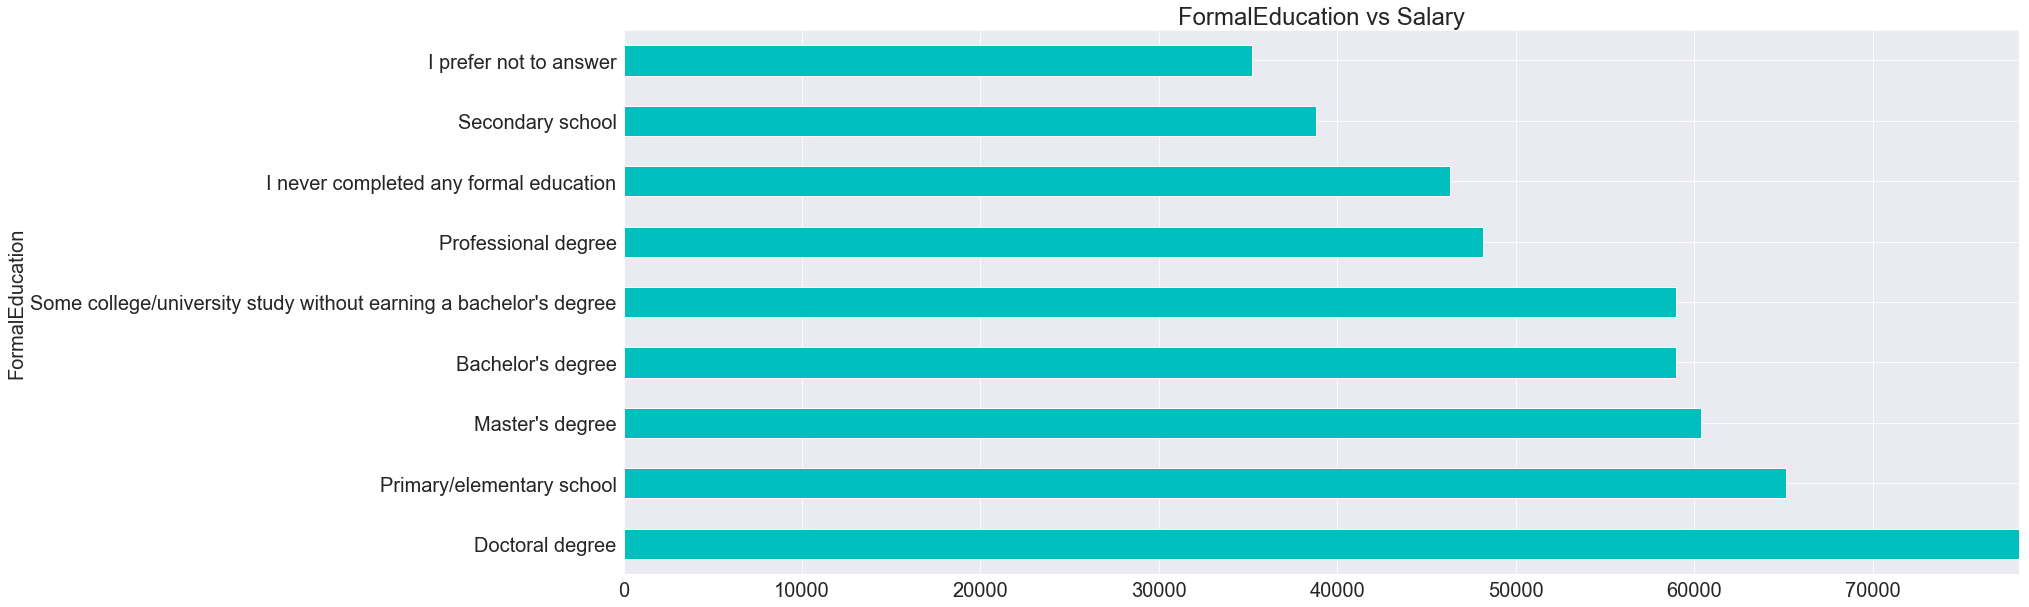

In [622]:
plots_series(FormalEducation_S, 'FormalEducation vs Salary', 'FormalEducation', 'barh', 0, 20)

In [461]:
#FormalEducation vs Satisfaction
#Nan values dropped to provide only relevant data, otherwise the graph will be cluttered.
FormalEducation=df.groupby(['FormalEducation']).mean()['JobSatisfaction'].sort_values(ascending = False).dropna()

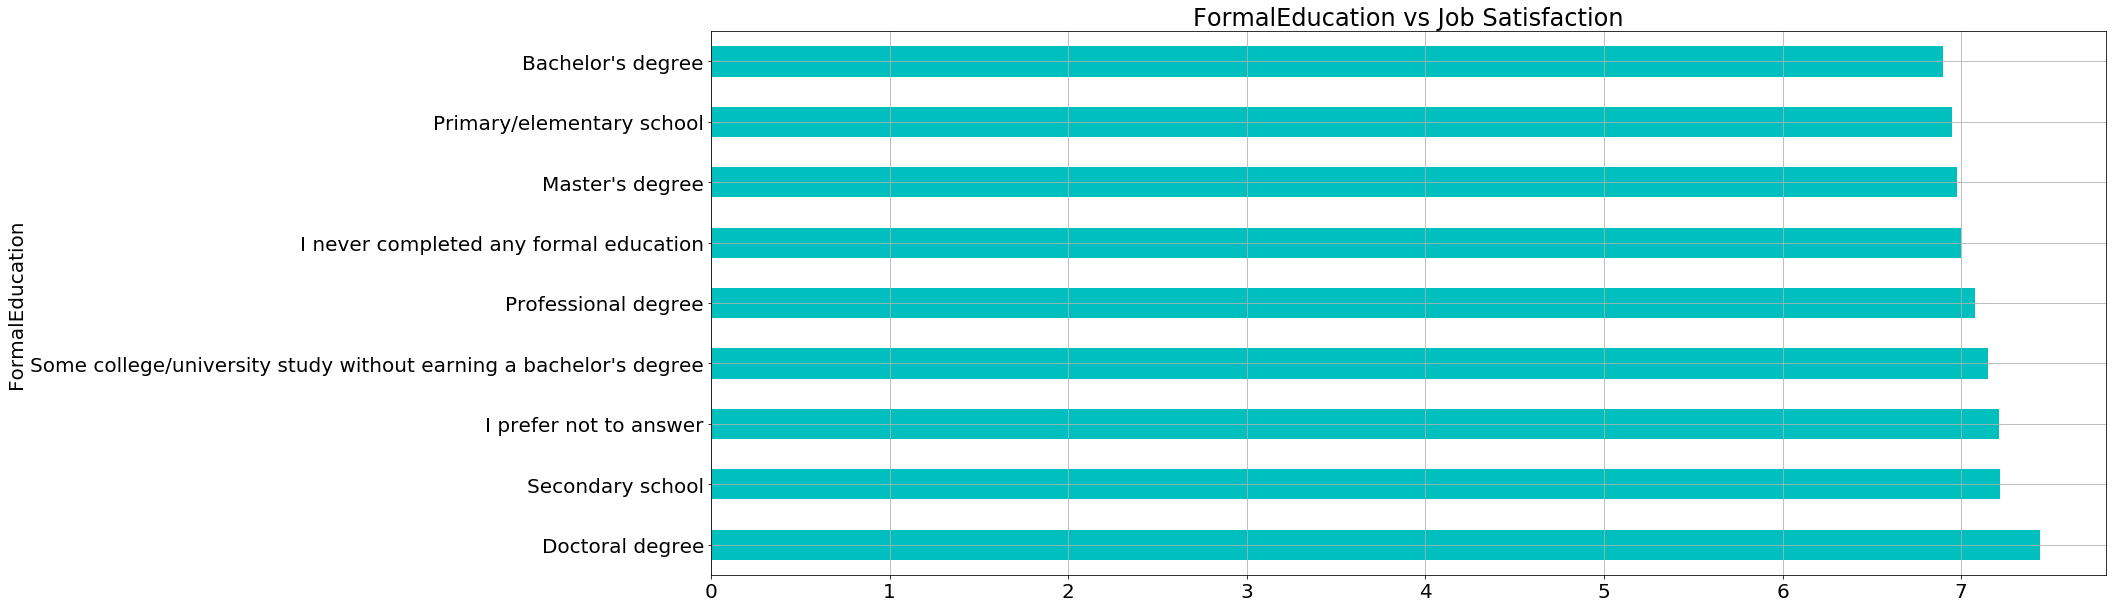

In [511]:
plots_series(FormalEducation, 'FormalEducation vs Job Satisfaction', 'FormalEducation', 'barh', 0, 20)

In [594]:
# Filter out the countries with greater than 30 samples
dfgre10 = dff[dff['count']>30]
listgre10=[]
listgre10=dfgre10.index
listgre10

Index(['United States', 'India', 'United Kingdom', 'Germany', 'Canada',
       'Poland', 'France', 'Australia', 'Netherlands', 'Israel',
       'Russian Federation', 'Spain', 'Italy', 'Sweden', 'Brazil', 'Romania',
       'Switzerland', 'Slovenia', 'Austria', 'Iran', 'Czech Republic',
       'Pakistan', 'Ukraine', 'Turkey', 'Belgium', 'Ireland', 'Finland',
       'Greece', 'Hungary', 'China', 'Mexico', 'South Africa', 'Denmark',
       'Philippines', 'Serbia', 'New Zealand', 'Indonesia', 'Japan',
       'Bulgaria', 'Norway', 'Argentina', 'Portugal', 'Croatia', 'Malaysia',
       'Bangladesh', 'Slovak Republic', 'South Korea', 'Singapore',
       'Lithuania', 'Hong Kong', 'Sri Lanka', 'I prefer not to say', 'Vietnam',
       'Colombia', 'Thailand', 'Egypt', 'Nepal', 'Taiwan',
       'United Arab Emirates', 'Latvia', 'Nigeria', 'Chile', 'Estonia',
       'Bosnia-Herzegovina', 'Dominican Republic', 'Uruguay', 'Belarus'],
      dtype='object')

In [625]:
# location vs Salary for countries with greater than 30 samples
#Nan values dropped to provide only relevant data, otherwise the graph will be cluttered.
location_s=df[df.Country.isin(listgre10)].groupby(['Country']).mean()['Salary'].sort_values(ascending = False).dropna()

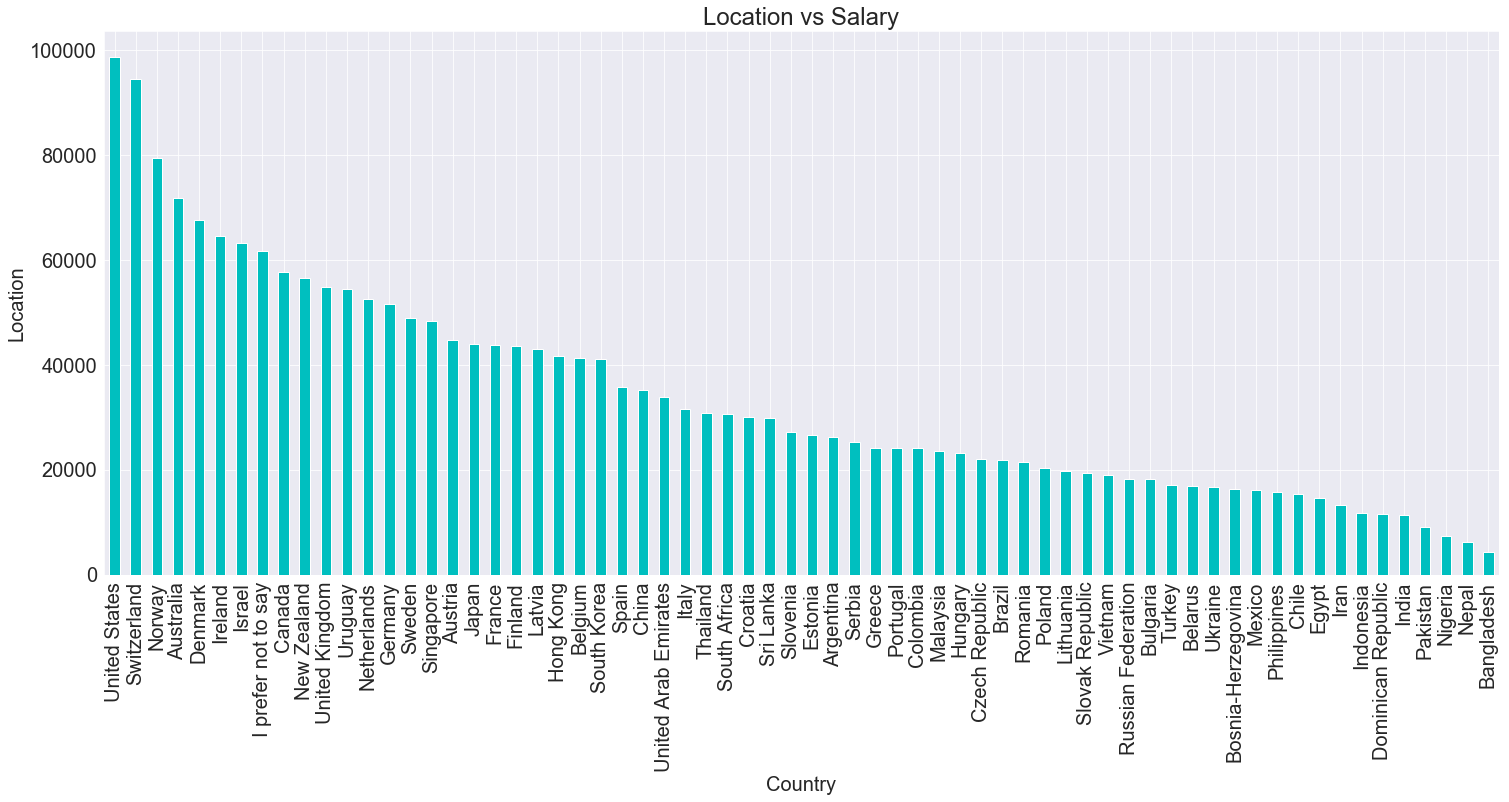

In [626]:
plots_series(location_s, 'Location vs Salary', 'Location', 'bar', 90, 20)

In [595]:
# location vs Satisfaction for countries with greater than 30 samples
#Nan values dropped to provide only relevant data, otherwise the graph will be cluttered.
location=df[df.Country.isin(listgre10)].groupby(['Country']).mean()['JobSatisfaction'].sort_values(ascending = False).dropna()location=df[df.Country.isin(listgre10)].groupby(['Country']).mean()['JobSatisfaction'].sort_values(ascending = False).dropna()

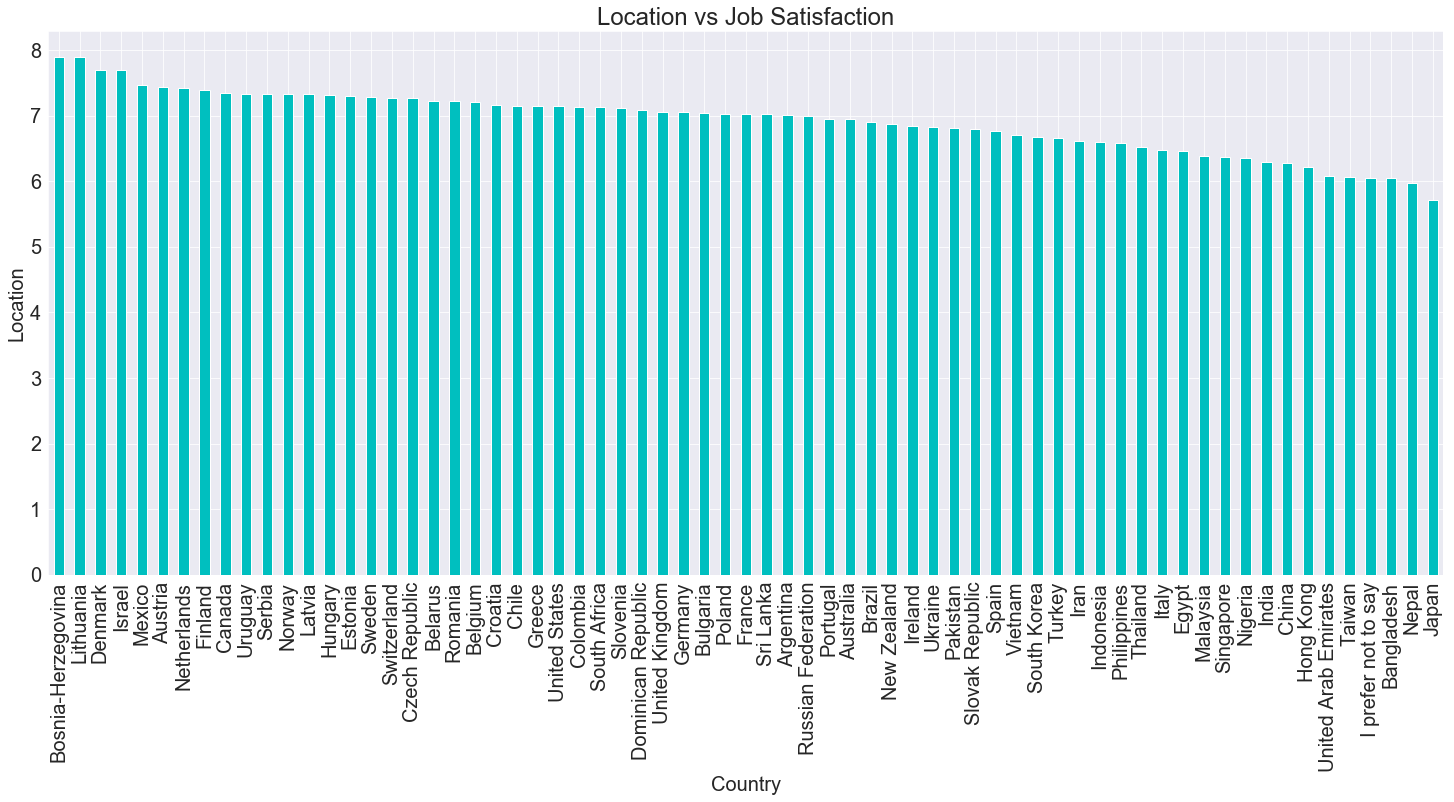

In [596]:
plots_series(location, 'Location vs Job Satisfaction', 'Location', 'bar', 90, 20)

In [623]:
# Hobby vs Salary
#Nan values dropped to provide only relevant data, otherwise the graph will be cluttered.
Hobby_S=df.groupby(['ProgramHobby']).mean()['Salary'].sort_values(ascending = False).dropna()

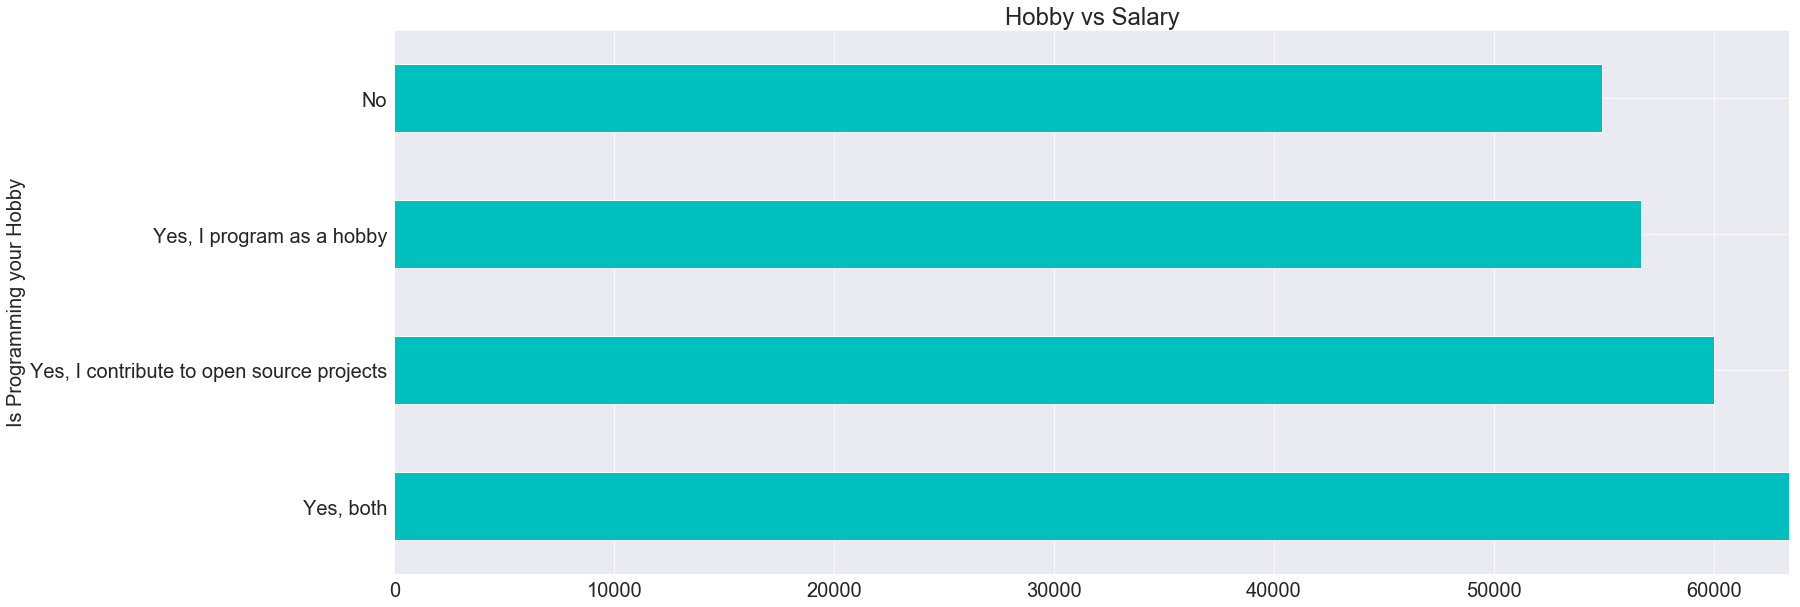

In [624]:
plots_series(Hobby_S, 'Hobby vs Salary', 'Is Programming your Hobby', 'barh', 0, 20)

In [631]:
# Satisfaction vs Salary
#Nan values dropped to provide only relevant data, otherwise the graph will be cluttered.
Job_Satisfaction=df.groupby(['JobSatisfaction']).mean()['Salary'].dropna()

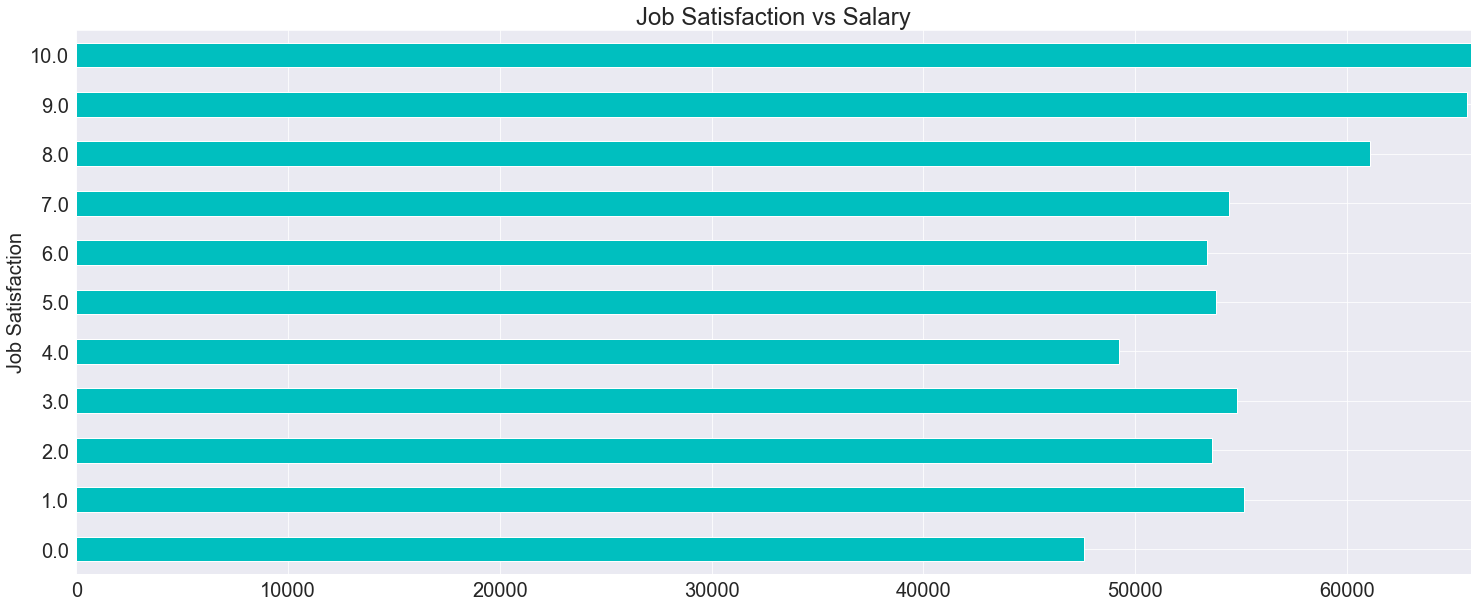

In [632]:
plots_series(Job_Satisfaction, 'Job Satisfaction vs Salary', 'Job Satisfaction', 'barh', 0, 20)

In [ ]:
#Hobby vs Satisfaction
#Nan values dropped to provide only relevant data, otherwise the graph will be cluttered.
Hobby=df.groupby(['ProgramHobby']).mean()['JobSatisfaction'].sort_values(ascending = False).dropna()

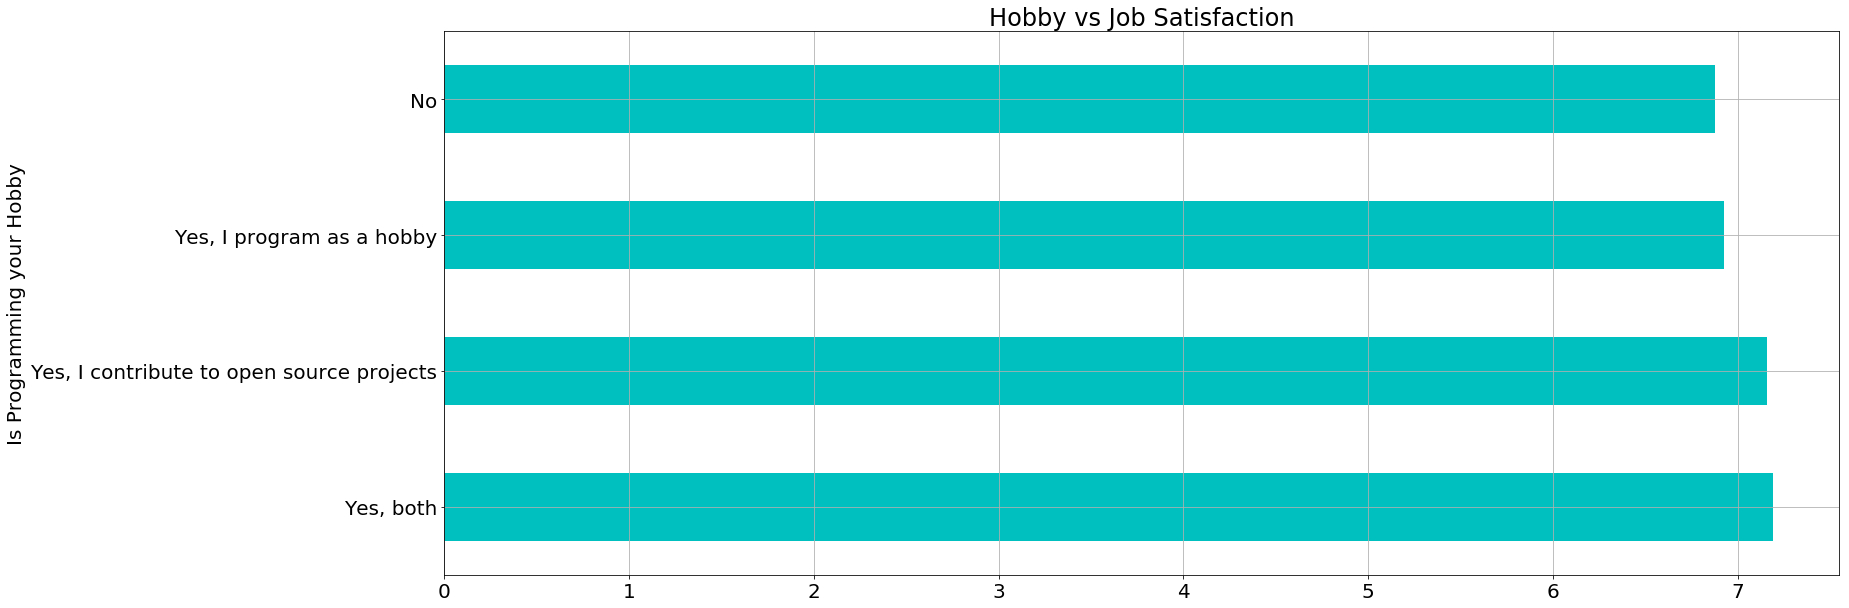

In [513]:
plots_series(Hobby, 'Hobby vs Job Satisfaction', 'Is Programming your Hobby', 'barh', 0, 20)